In [27]:
import numpy as np
import os
from itertools import chain, product
from sklearn.metrics import accuracy_score, f1_score
from math import log
from matplotlib import pyplot as plt

In [28]:
ps = {}
datax, datay = [], []
for _ in range(10):
    datax.append([])
    datay.append([])    
dim = 25000

In [29]:
def pairs(x):
    n = len(x) + 2
    x = list(chain([-1], x, [-2]))
    
    x_pairs = []
    for i in range(n - 1):
        x_pairs.append((min(x[i], x[i + 1]), max(x[i], x[i + 1])))
    return x_pairs

In [30]:
def pair_data(datax):
    newdata = []
    for d in datax:
        newdata.append(list(map(lambda msg: (pairs(msg[0]), pairs(msg[1])), d)))
    return newdata

In [31]:
strtonp = lambda s: np.array(list(map(int, s.strip().split())))

for i in range(1, 11):
    dirname = 'Bayes/pu1/part' + str(i) + '/'
    for fname in os.listdir(dirname):
        with open(dirname + fname) as f:
            sbj = f.readline()[8:]
            f.readline()
            body = f.readline()
            
            datax[i - 1].append((strtonp(sbj), strtonp(body)))
            datay[i - 1].append(int('legit' in fname))
pdatax = pair_data(datax)

In [32]:
def split(i, datax, datay):
    x_train = []
    y_train = []
    for j in range(10):
        if j == i:
            x_test = datax[i]
            y_test = datay[i]
        else:
            x_train += datax[j]
            y_train += datay[j]
    return x_train, y_train, x_test, y_test

In [33]:
def calc_probs_multinomial(x_train, y_train):
    word_lkhd = {'sbj' : [{}, {}], 'bdy' : [{}, {}]}
    words_count = {'sbj' : [0, 0], 'bdy' : [0, 0]}
    legitcount = 0
    size = len(x_train)
    
    for ((sbj, bdy), c) in zip(x_train, y_train):
        legitcount += c
        words_count['sbj'][c] += len(sbj)
        words_count['bdy'][c] += len(bdy)
        
        for word in sbj:
            word_lkhd['sbj'][c].setdefault(word, 0)
            word_lkhd['sbj'][c][word] += 1
        for word in bdy:
            word_lkhd['bdy'][c].setdefault(word, 0)
            word_lkhd['bdy'][c][word] += 1
            
    for c in range(2):
        for part in ['sbj', 'bdy']:
            for word in word_lkhd[part][c]:
                word_lkhd[part][c][word] += 1
                word_lkhd[part][c][word] /= words_count[part][c] + dim
    return [1 - legitcount / size, legitcount / size], word_lkhd, words_count

In [126]:
maxt = 1e50

In [127]:
def predict_multinomial(x, threshold, probclass, word_lkhd, words_count, sbj_weight, yy = None):
    global maxt
    sbj, bdy = x
    lks = [0, 0]
           
    def logp(part, word, c):
        if word not in word_lkhd[part][c]:
            return log(1 / (words_count[part][c] + dim))
        else:
            return log(word_lkhd[part][c][word])
        
    for c in range(0, 2):
        for word in sbj:
            lks[c] += sbj_weight * logp('sbj', word, c)
        for word in bdy:
            lks[c] += logp('bdy', word, c)
        lks[c] += log(probclass[c])
    if yy == 1:
        maxt = min(maxt, lks[1] - lks[0])
    return int(lks[1] - lks[0] > threshold)

In [128]:
class MultinomialBayes:
    def __init__(self, threshold, sbj_weight):
        self.threshold = threshold
        self.sbj_weight = sbj_weight
        
    def fit(self, X, Y):
        global ps
        if id(X) not in ps:
            ps[id(X)] = calc_probs_multinomial(X, Y)
        self.probclass, self.word_lkhd, self.words_count = ps[id(X)]
        for x, y in zip(X, Y):
            predict_multinomial(x, self.threshold,\
                                             self.probclass, self.word_lkhd, 
                                             self.words_count, self.sbj_weight, y)
    
    def predict(self, X):
        return np.array([predict_multinomial(x, self.threshold,\
                                             self.probclass, self.word_lkhd, 
                                             self.words_count, self.sbj_weight) for x in X])

In [129]:
def cross_validate(model, xy_folds, Q):
    cv = 0
    for x_train, y_train, x_test, y_test in xy_folds:
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        cv += Q(y_test, y_pred) / len(xy_folds)
    return cv

In [130]:
class GridSearch:
    def __init__(self, model, Q, params):
        self.model = model
        self.params = params
        self.Q = Q
    
    def fit(self, datax, datay):
        pkeys = self.params.keys()
        pvalues = list(product(*self.params.values()))
        res = []
        
        xy_folds = []
        for i in range(10):
            xy_folds.append(split(i, datax, datay))
        
        for v in pvalues:
            local_ps = dict(zip(pkeys, v))
            res.append((cross_validate(self.model(**local_ps), xy_folds, self.Q), local_ps))
        
        minv = 1e10
        for cv, ps in res:
            if cv < minv:
                minv = cv
                self.best_params = ps
                self.best_error = cv
        return res

In [131]:
def draw_roc(model, min_threshold, max_threshold, x_train, y_train, x_test, y_test):
    model.fit(x_train, y_train)
    fpr = []
    tpr = []
    pos = sum(y_test)
    neg = len(y_test) - pos
    for t in np.arange(min_threshold, max_threshold, (max_threshold - min_threshold) / 300):
        model.threshold = t
        y_pred = model.predict(x_test)
        
        fpr.append(fp(y_test, y_pred) / neg)
        tpr.append(tp(y_test, y_pred) / pos)
    
    plt.plot(fpr, tpr)
    plt.show()

In [132]:
def L(y_true, y_pred):
    return sum(abs(y_true - y_pred))
def tp(y_true, y_pred):
    return sum(y_true & y_pred)
def fp(y_true, y_pred):
    return sum(map(lambda t_p: t_p[0] == 0 and t_p[1] == 1, zip(y_true, y_pred)))
def tn(y_true, y_pred):
    return sum(map(lambda t_p: t_p[0] == 0 and t_p[1] == 0, zip(y_true, y_pred)))
def fn(y_true, y_pred):
    return sum(map(lambda t_p: t_p[0] == 1 and t_p[1] == 0, zip(y_true, y_pred)))
def f1(y_true, y_pred):
    return f1_score(y_true, y_pred)
def f1Q(y_true, y_pred):
    return 1 - f1_score(y_true, y_pred)

In [133]:
params = {
    'threshold' : np.arange(-1.2, 1.0, 0.5),
    'sbj_weight' : np.arange(3.8, 5, 0.3)
}

In [134]:
x_tr, y_tr, x_te, y_te = split(2, datax, datay)

In [137]:
maxt

-158.71477700093055

In [146]:
m = MultinomialBayes(**gs.best_params)
m.fit(x_tr, y_tr)
y_pred = m.predict(x_tr)
print('f1:', f1_score(y_tr, y_pred))
print('fn:', sum([y1 == 0 and y2 == 1 for y1, y2 in zip(y_pred, y_tr)]))

m.threshold = maxt - 1e-10
y_pred = m.predict(x_tr)
print('f1:', f1_score(y_tr, y_pred))
print('fn:', sum([y1 == 0 and y2 == 1 for y1, y2 in zip(y_pred, y_tr)]))


f1: 0.985294117647
fn: 13
f1: 0.869358669834
fn: 0


In [21]:
gs = GridSearch(MultinomialBayes, f1Q, params)
res = gs.fit(datax, datay)

In [22]:
print('Best params:', gs.best_params)
print('f1:', 1 - gs.best_error)

Best params: {'threshold': -1.0, 'sbj_weight': 4.2000000000000002}
f1: 0.969198896623


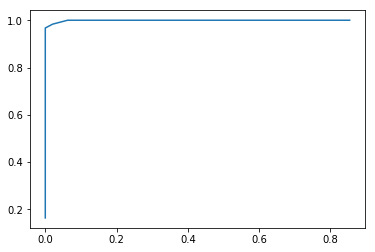

In [23]:
draw_roc(MultinomialBayes(**gs.best_params), -1000, 1000, *split(0, datax, datay))

In [24]:
gs1 = GridSearch(MultinomialBayes, f1Q, params)
res1 = gs1.fit(pdatax, datay)

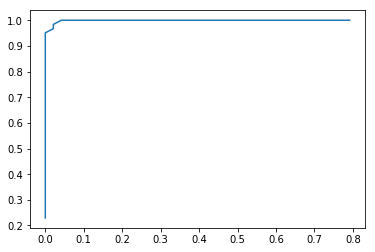

In [25]:
draw_roc(MultinomialBayes(**gs.best_params), -1000, 1000, *split(0, pdatax, datay))